# Imperfect tests

This model includes the sensitivity and specificity of the diagnostic test. 

\begin{equation}
  \begin{aligned}
    T_i &\sim \operatorname{Bernoulli}(p_i) \\
    p_i &= \gamma_s\theta_i + (1-\gamma_e)(1 - \theta_i),  \\
    g(\theta_i) &= g(\theta) + \boldsymbol{x}_i^T\beta,  \\
    \beta &\sim \operatorname{Normal}(\mu, \Sigma), \\ 
    \theta &\sim \operatorname{Beta}(a^p, b^p) \\
    \gamma_s &\sim \operatorname{Beta}(a^s, b^s), \\
    \gamma_e &\sim \operatorname{Beta}(a^e, b^e), \\    
  \end{aligned}  
\end{equation}

where $a^p, a^s, a^e, b^p, b^s, b^e \in \mathbb{R}_{++}$ are fixed hyperparameters.
This model does not include prior knowledge about the correlation between specificity and sensitivity. 


In [1]:
import numpy as np
import pystan as ps
from scipy.special import logit, expit

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

import pickle

import sys  
sys.path.insert(0, '../scripts/')

## Notebook settings

In [23]:
sns.set()
plt.rc('mathtext', fontset="cm")
ro = np.random.RandomState(1000)
%matplotlib inline

## Stan code 

Below we can see the code written in Stan. 

In [3]:
#compiled = False
compiled = True

if compiled: 
    sm = pickle.load(open('../models/primary_model/pickles/imperfect_test.pkl', 'rb'))
else: 
    sm = ps.StanModel(file = '../models/primary_model/stan_codes/imperfect_test.stan')
    with open('../models/primary_model/pickles/imperfect_test.pkl', 'wb') as f:
        pickle.dump(sm, f)

Below wee see the required data and model parameters. 

In [4]:
print(sm.model_code[:-765])

data {
    int<lower = 0> n_samples;
    int<lower = 0> n_predictors; 
  
    int T[n_samples];
    matrix[n_samples, n_predictors] x;
    
    cov_matrix[n_predictors] Sigma; 
    vector[n_predictors] mu;
    real<lower = 0> alpha_p; 
    real<lower = 0> beta_p;
    real<lower = 0> alpha_s; 
    real<lower = 0> beta_s;
    real<lower = 0> alpha_e; 
    real<lower = 0> beta_e;
}
parameters {
    vector[n_predictors] effects; 
    real<lower = 0, upper = 1> prev;
    real<lower = 0, upper = 1> sens;
    real<lower = 0, upper = 1> spec;
}


And now the model

In [5]:
print(sm.model_code[-765:-302])


transformed parameters {
    vector[n_samples] theta;
    vector[n_samples] p; 
    
    for (i in 1:n_samples) {
        theta[i] = inv_logit(logit(prev) + x[i] * effects);
        p[i] = sens*theta[i] + (1 - spec)*(1 - theta[i]);
    }
}
model {
    effects ~ multi_normal(mu, Sigma);
    prev ~ beta(alpha_p, beta_p);
    
    sens ~ beta(alpha_s, beta_s);
    spec ~ beta(alpha_e, beta_e);

    for (i in 1:n_samples) {
       T[i] ~ bernoulli(p[i]);
    }
}


## Toy example

First we describe data created artificially as it was generated by this model.
It serves as a confirmation of functionality of the code. 

In [24]:
n_samples    = 200
n_predictors = 5  
  
x = ro.multivariate_normal(mean = np.zeros(n_predictors), 
                           cov = np.eye(n_predictors),
                           size = n_samples)

# Normalization
x = (x - x.mean(axis=0))/x.std(axis = 0, ddof = 1)

Note that we generate $x$ in the same way as for perfect tests model tests. 

In [25]:
# Parameters we want to estimate
spec = 0.85
sens = 0.8

beta = np.array([0.1, 2.5, -1.0, 1.2, -0.3]).reshape(-1,1)
prevalence = 0.1

# Generated quantities

theta = expit(logit(prevalence) + x@beta)
p = sens*theta + (1 - spec)*(1 - theta)

T  = ro.binomial(n = 1, p = p)

# Hyperparameters to the estimation process
alpha_s = 4
beta_s  = 1
alpha_e = 8
beta_e  = 2
alpha_p = 3
beta_p  = 9
Sigma   = np.eye(5)
mu      = np.zeros(5)

# Data for the Stan code
data = {
    "n_samples"    : n_samples,
    "n_predictors" : n_predictors,
    "T"            : T.flatten(),
    "x"            : x,
    
    "Sigma"        : Sigma,
    "mu"           : mu,
    "alpha_p"      : alpha_p,
    "beta_p"       : beta_p,
    "alpha_s"      : alpha_s,
    "beta_s"       : beta_s,
    "alpha_e"      : alpha_e,
    "beta_e"       : beta_e,
}

T.mean()

0.31

How the numerical part of the problem enters the picture

In [26]:
%%time
fit_imperfect = sm.sampling(data=data, iter=5000)
summary = az.summary(fit_imperfect)

CPU times: user 32.2 s, sys: 96.3 ms, total: 32.3 s
Wall time: 38.6 s


Something strange has happened: Rhat > 1.1. Below we can observe in the trace
plot why. There are two groups of chains (2 for each one) and they do not mix,
searching for very different parts of the space. It appears very strange for
me that `prev` has a chain with high mean, despite we have put it to be 0.1.

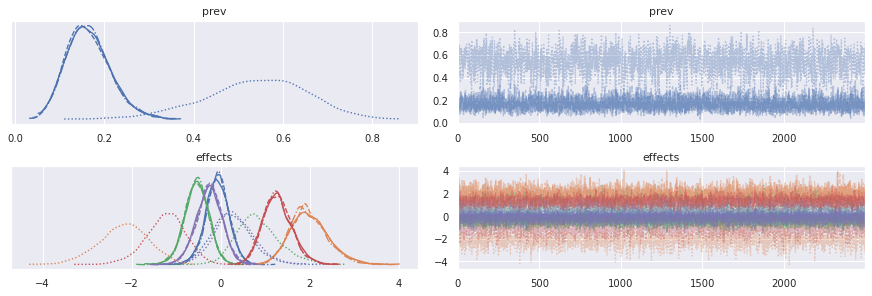

In [27]:
az.plot_trace(fit_imperfect, var_names=('prev', 'effects'))
plt.show()

Note that the prior of $\theta$ is very sharp after $\theta > 0.6$ and that is
very strange...

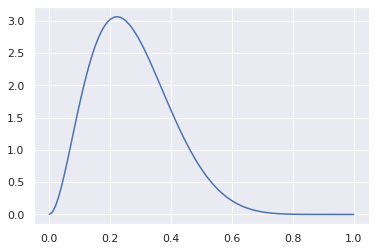

In [29]:
from scipy.stats import beta

t = np.linspace(0,1,100)
x = beta(a = alpha_p, b = alpha_e).pdf(t)

plt.plot(t,x)
plt.show()

In order to verify why it happened, we tested with another $T$ (array with
positive or negative tests for each individual) and the problem was missing. 

In [30]:
%%time
T2 = ro.binomial(n = 1, p = p)
data['T'] = T2.flatten()
fit_imperfect = sm.sampling(data=data, iter=5000)
summary = az.summary(fit_imperfect)

CPU times: user 8.05 s, sys: 120 ms, total: 8.17 s
Wall time: 17.7 s


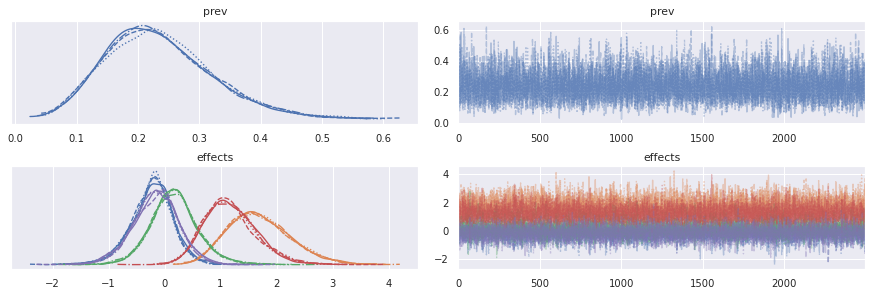

In [32]:
az.plot_trace(fit_imperfect, var_names=('prev', 'effects'))
plt.show()

Why? The means and vars are so close...

In [36]:
print(T.mean())
print(T2.mean())
print(T.var())
print(T2.var())

0.31
0.32
0.21389999999999998
0.21759999999999993


### Sanity check

We already know that $\theta_i$ is linear on $p_i$. Let's check this getting
the estimated means for $\theta$ and $p$ among the individuals. 

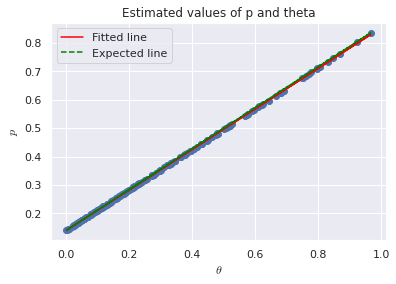

In [15]:
theta_values = summary[summary.index.str.contains('theta')]['mean']
p_values = summary[summary.index.str.contains('p\[')]['mean']

line_parameters = np.polyfit(theta_values, p_values, deg = 1)

spec_hat = summary.loc['spec', 'mean']
sens_hat = summary.loc['sens', 'mean']

plt.scatter(theta_values, p_values)
plt.plot(theta_values, theta_values * line_parameters[0] + line_parameters[1], 
         color = 'red', label = 'Fitted line')
plt.plot(theta_values, theta_values * (spec_hat + sens_hat - 1) + (1 - spec_hat), 
         color = 'green', label = 'Expected line', linestyle = '--')
plt.title('Estimated values of p and theta')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p$')
plt.legend()
plt.show()